# Prepare the environment

Setup the `matplotlib` environment to look pretty.

In [1]:
import matplotlib.pyplot
# Show the plots inside the notebook.
%matplotlib inline
# Make the figures high-resolution.
%config InlineBackend.figure_format='retina'
# Various font sizes.
ticksFontSize=18
labelsFontSizeSmall=20
labelsFontSize=30
titleFontSize=34
legendFontSize=14
matplotlib.rc('xtick', labelsize=ticksFontSize) 
matplotlib.rc('ytick', labelsize=ticksFontSize)
# Colourmaps.
cm=matplotlib.pyplot.cm.get_cmap('viridis')

# Introduction

Compare the simulated outliers in the "training time series" of each orbital element to the actual outliers present in the TLEs. First, though, need to prepare the training time series of mean motion $n$, inclination $i$ and eccentricity $e$ (use a related quantity, perigee radius $r_p=(1-e)a$) on which the individual filters will be tested. The required steps are:

1. Load TLE orbital elements.
2. Filter out corrected TLEs.
3. Run a moving window with a robust polynomial through the TLE orbital elements to smoothen the data.
4. Generate the training time series = re-sample the orbital element from 3 at equally spaced epochs and simulate the outliers.
5. Resample the time series from 3 at the actual TLE epochs and compute the magnitude of the outliers present in the TLEs.
6. Compare the simulated outleirs from 4 to the actual ones from 5.

## Script controls

Choose the whether to automatically save figures besides showing them, save the raw data, and which object to analyse.

In [2]:
SSC=13025 # Will work with this object

# Load TLEs

Do not parse the TLEs because that requires a parser function, which forms a part of the proprietary ESA code. Load already parsed elements extracted from the TLEs.

In [3]:
import os, numpy

meanMotions=numpy.load('{}MeanMotions.npy'.format(SSC))
eccentricities=numpy.load('{}eccentricities.npy'.format(SSC))
inclinations=numpy.load('{}inclinations.npy'.format(SSC))
epochsJD=numpy.load('{}epochsJD.npy'.format(SSC),)
epochs=numpy.load('{}epochs.npy'.format(SSC))
print("Read {} TLEs for {}.".format(meanMotions.size,SSC))

Read 2224 TLEs for 13025.


# Pre-process the TLEs

Need to remove corrected TLEs from the time series, they will make resampling produce dodgy results.

In the case of `13025` object, also remove the last TLE - it would be marked as an epoch outlier by `findNAndTOutliersAndSeqeunces` but we won't be running the filters here, so need to remove that TLE manually.

The function to fitler corrected TLEs forms part of a proprietary code. However, its resuls for `13025` have been saved to `npy` files to allow the results to be reproduced. `outlierFlags` equal to 1 correspond to TLEs that are followed by another TLE published less than half an orbital period later, i.e. are believed to have been corrected.

In [4]:
# Identify the TLEs that have been corrected, i.e.
# preceed the next one by less than 0.5 orbital period.
# Filtering code not included.
outlierFlags=numpy.load('{}outlierFlags.npy'.format(SSC))
sequenceIDs=numpy.load('{}sequenceIDs.npy'.format(SSC))
print("Found {} corrected TLEs.".format(numpy.sum(
      outlierFlags==1))) # TLEFiltering.OUTLIER_TYPES['corrected']=1

Found 398 corrected TLEs.


In [5]:
# Get rid of the last TLE for 13025, it's an obvious epoch outlier.
if SSC==13025:
    print("The last TLE comes after a gap of "
          "{:.4f} days after the previous one.".format(epochsJD[-1]-
                                                   epochsJD[-2]))
    epochs=epochs[:-1]
    epochsJD=epochsJD[:-1]
    meanMotions=meanMotions[:-1]
    eccentricities=eccentricities[:-1]
    inclinations=inclinations[:-1]
    outlierFlags=outlierFlags[:-1]
    sequenceIDs=sequenceIDs[:-1]

The last TLE comes after a gap of 1206.8514 days after the previous one.


# Process the time series

Need to first smoothen the original TLE time series, then prepare to resample them at desired epochs (equal 1 day intervals or original TLE epochs).

## Smoothen the time series

Use [LOWESS](https://en.wikipedia.org/wiki/Local_regression) non-parameteric regression to smoothen the time series of $n$, $e$ and $i$. This removes the noise and outliers.

The LOWESS settings for every time series were choosen by comparing the values interpolated using a smoothed subset  of the TLEs to the complement of this subset. A test subset from the data was selected. The remainder, i.e. the training subset, was smoothed using LOWESS and interpolated on the epochs of the test subset. The discrepancies between the test subset and the interpolation was then minimised to yield the best LOWESS settings.

First, get rid of the corrected TLEs from the time series.

In [6]:
epochs=numpy.delete(epochs,numpy.where(outlierFlags==1))
epochsJD=numpy.delete(epochsJD,numpy.where(outlierFlags==1))
meanMotions=numpy.delete(meanMotions,numpy.where(outlierFlags==1))
eccentricities=numpy.delete(eccentricities,numpy.where(outlierFlags==1))
inclinations=numpy.delete(inclinations,numpy.where(outlierFlags==1))

Required imports.

In [7]:
import statsmodels.api as sm
import statsmodels
assert statsmodels.__version__>='0.6.1'
import scipy.interpolate
assert scipy.__version__>='0.18.1'

Use optimised LOWESS settings to smoothen time series of all orbital elements.

In [8]:
lwMeanMotions=sm.nonparametric.lowess(meanMotions,epochsJD,
                                      frac=2.98e-3, # Fraction of data
                                      # to use to smoothen each point.
                                      it=0, # No. re-weightings.
                                      delta=0, # Distance within which
                                      # unweighted regression
                                      # will be used.
                                      missing='raise',is_sorted=True,
                                      return_sorted=False)

In [9]:
lwInclinations=sm.nonparametric.lowess(inclinations,epochsJD,
                                       frac=1.65e-2,it=0,delta=0,
                                       missing='raise',
                                       is_sorted=True,
                                       return_sorted=False)

In [10]:
lwEccentricities=sm.nonparametric.lowess(eccentricities,epochsJD,
                                         frac=5.75e-3,it=0,delta=0,
                                         missing='raise',
                                         is_sorted=True,
                                         return_sorted=False)

## Re-sample the time series

Prepare the interpolation of the time series of $n$, $e$ and $i$.

In [11]:
import pandas as pd
assert pd.__version__>='0.18.1'

Cubic interpolation seems to work well. Linear has sharp gradient changes at the beinning and end of time gaps, and quadratic has large overshoots. Behaviour across the time gaps is even worse for kernel-based approaches from `scikit.learn`, which have an even larger overshoot.

In [12]:
meanMotionInterp=scipy.interpolate.interp1d(epochsJD,lwMeanMotions,
                                            kind='cubic',
                                            bounds_error=True,
                                            assume_sorted=True)

In [13]:
eccentricityInterp=scipy.interpolate.interp1d(epochsJD,lwEccentricities,
                                            kind='cubic',
                                            bounds_error=True,
                                            assume_sorted=True)

In [14]:
inclinationInterp=scipy.interpolate.interp1d(epochsJD,lwInclinations,
                                            kind='cubic',
                                            bounds_error=True,
                                            assume_sorted=True)

# Compare actual outliers to the simulated ones

## Generate "training time series"

Resample the time series of $n$, $e$ and $i$ on a grid of equal, one-day time spacing. One-day time spacing is pretty reasonable for TLE update frequency. At the end of this, we'll have pristine time series into which we'll add outliers to have "training time series" of all orbital elements.

In [15]:
# Epochs at which we'll resample the data to have pristine time series.
# N.B. the epochs are the same for the training time series as well.
epochsJDOneDay=numpy.arange(epochsJD[0],epochsJD[-1]+1e-3,1.0) # Span the original TLE time series epochs.
epochsOneDay=pd.date_range(epochs[0],epochs[-1],freq='1D')

In [16]:
# Pristine time series w/o any outliers.
meanMotionPristine=meanMotionInterp(epochsJDOneDay)
eccentricityPristine=eccentricityInterp(epochsJDOneDay)
inclinationPristine=inclinationInterp(epochsJDOneDay)

Add sequences to the mean motion time series, they're the cause of the 
need for false +ve and -ve trade-off. Put sequences in different $\dot{n}$
phases of the decay. Make them larger than largest outliers (10%).
Use varying lengths of sequences to be robust (30, 40, 50, 60 TLEs).

In [17]:
meanMotionPristine[:30]*=0.8 # Arbitrary, at the time series start.
meanMotionPristine[650:690]*=1.2 # 1 Oct 83
meanMotionPristine[1077:1127]*=1.2 # 1 Dec 84
meanMotionPristine[1685:1745]*=1.2 # 1 Aug 86
meanMotionPristine[2385:2415]*=1.2 # 1 Jul 88

Load the saved outlier data, which have been chosen so as to include outliers in various phases of orbital decay, and to include different combinations of outliers (single, double consecutive etc.).

In [18]:
# Multiply pristine time series values by some factor, 0 for non-outliers.
outlierMultipliers_n=numpy.loadtxt('{}NOutlierMultipliers.csv'.format(SSC))
outlierMultipliers_e=numpy.loadtxt('{}EOutlierMultipliers.csv'.format(SSC))
outlierMultipliers_i=numpy.loadtxt('{}IOutlierMultipliers.csv'.format(SSC))

# Maximum size of the outliers relative to the pristine time series.
maxSimulatedOM_n=0.1
maxSimulatedOM_e=0.25
maxSimulatedOM_i=0.25

Add outliers into the pristine time series to generate training time series. Here only use the largest possible outlier magnitude. In the optimisation, a range of outlier magnitudes were used to ensure the optimisised filters would also identify small outliers.

In [19]:
# outlierMultipliers != 0 give outleir direction (and size relative to other otuliers),
# OM gives the size of the outliers relative to the pristine time series.
meanMotionTraining=meanMotionPristine + maxSimulatedOM_n*outlierMultipliers_n*meanMotionPristine
eccentricityTraining=eccentricityPristine +  maxSimulatedOM_e*outlierMultipliers_e*eccentricityPristine
inclinationTraining=inclinationPristine + maxSimulatedOM_i*outlierMultipliers_i*inclinationPristine

## Compute the real outlier maginitude

Find the differences between the smoothed time series and real TLEs - this is the magnitude of outliers that we have observed for this object, if we assume that the smoothed time series represents the actual time series of a given orbital element.

First, resample $n$, $e$ and $i$ at the TLE epochs.

In [20]:
meanMotionResampledAtTLEEpochs=meanMotionInterp(epochsJD)
eccentricityResampledAtTLEEpochs=eccentricityInterp(epochsJD)
inclinationResampledAtTLEEpochs=inclinationInterp(epochsJD)

Find the largest outliers in the three orbital elements. Treat the smoothed time series as a reference, w.r.t. which we compute the outlier magnitudes, `OM`s. We simulate the outliers w.r.t. same reference to generate the "training time series".

In [21]:
realOM_n=numpy.abs((meanMotions-meanMotionResampledAtTLEEpochs)/meanMotionResampledAtTLEEpochs)
realOM_e=numpy.abs((eccentricities-eccentricityResampledAtTLEEpochs)/eccentricityResampledAtTLEEpochs)
realOM_i=numpy.abs((inclinations-inclinationResampledAtTLEEpochs)/inclinationResampledAtTLEEpochs)
maxRealOM_n=max(realOM_n)
maxRealOM_e=max(realOM_e)
maxRealOM_i=max(realOM_i)

## Compare the simulated and real outliers

Compare the magnitudes of the simulated and real outliers, and plot histograms of the outliers in every orbital element. Also plot the time series of $n$, $e$ and $i$ with the largest simulated outliers against the actual TLE time series of the given element and the pristine time series, which we treat as reference time series for every orbital element.

Ratio of simulated to real outlier magnitudes greater than `1.0` signifies that we've simulated outliers greater than we've actually seen for this object. Ratios lower than `1.0` signify the opposite, i.e. that we haven't simulated outliers as big as we know happen for real objects.

In [22]:
# Print the largest outliers in different elements.
print('The largest n OM, simulated={:.4f}, real={:.4f},ratio={:.4f}.'.format(
    maxSimulatedOM_n,maxRealOM_n,maxSimulatedOM_n/maxRealOM_n))
print('The largest e OM, simulated={:.4f}, real={:.4f},ratio={:.4f}.'.format(
    maxSimulatedOM_e,maxRealOM_e,maxSimulatedOM_e/maxRealOM_e))
print('The largest i OM, simulated={:.4f}, real={:.4f},ratio={:.4f}.'.format(
    maxSimulatedOM_i,maxRealOM_i,maxSimulatedOM_i/maxRealOM_i))

The largest n OM, simulated=0.1000, real=0.0152,ratio=6.5742.
The largest e OM, simulated=0.2500, real=0.1024,ratio=2.4414.
The largest i OM, simulated=0.2500, real=0.0199,ratio=12.5412.


/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


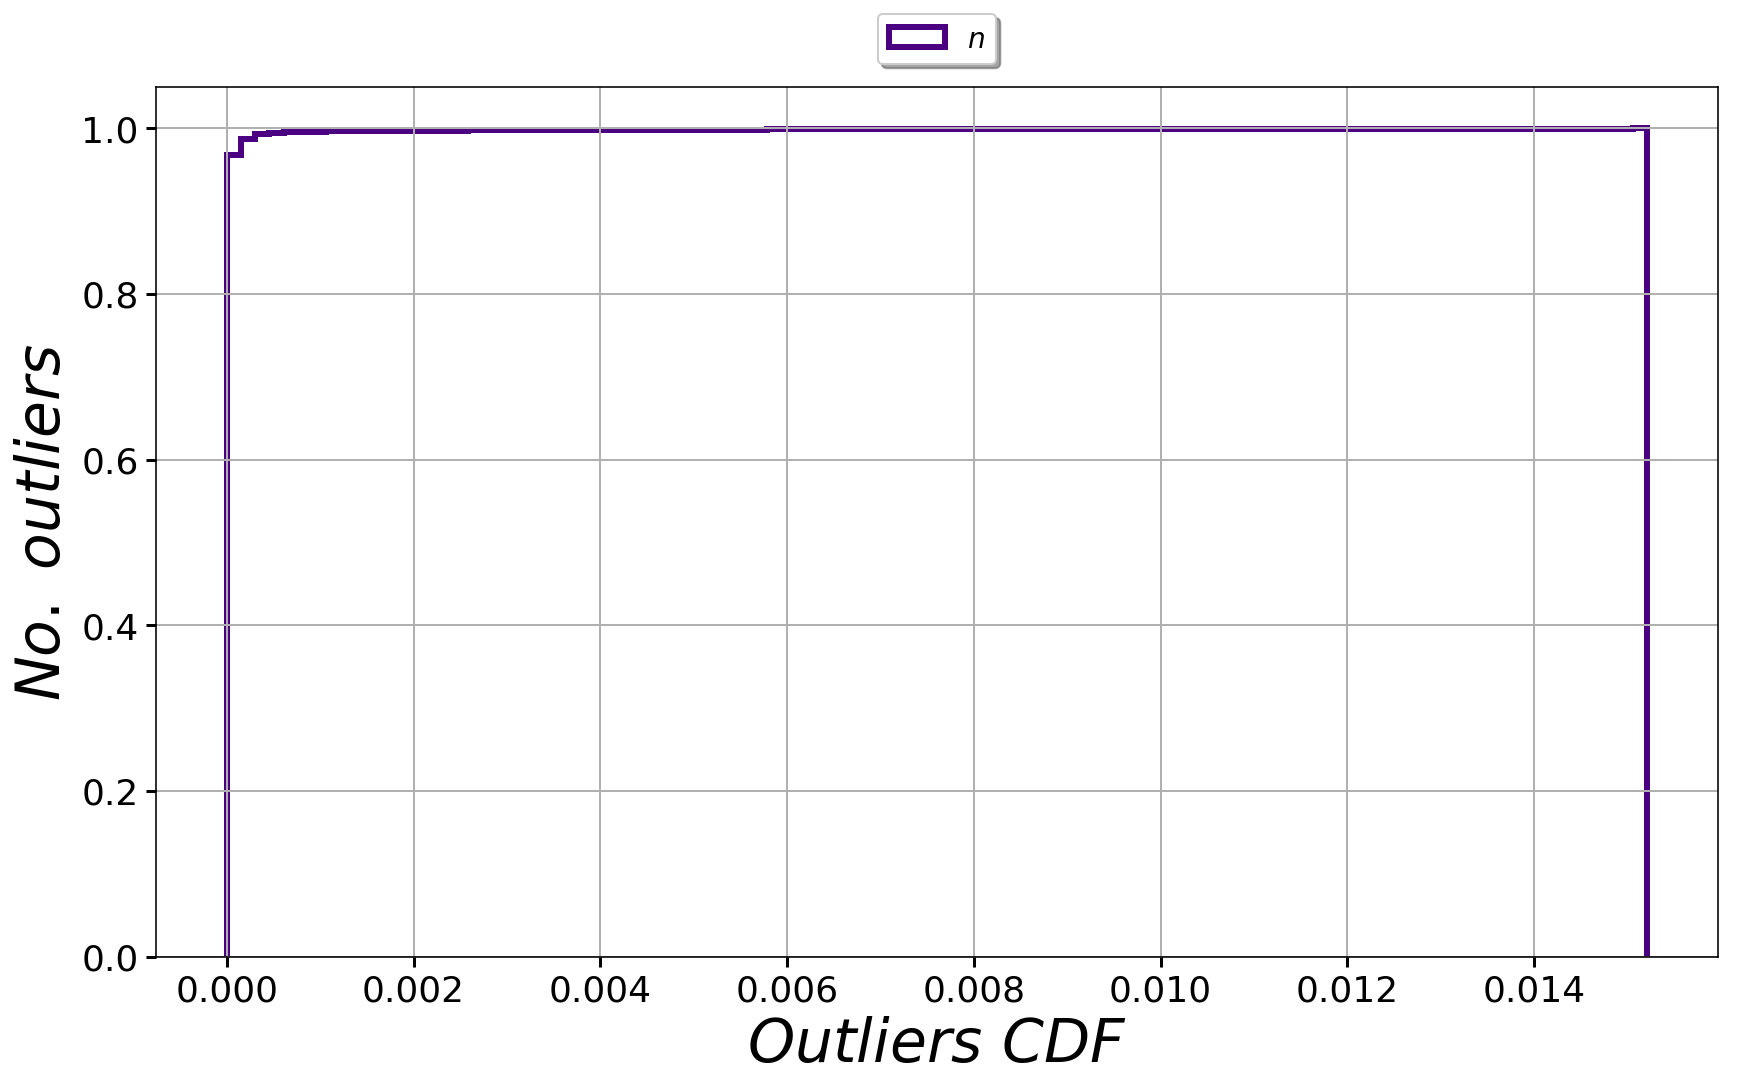

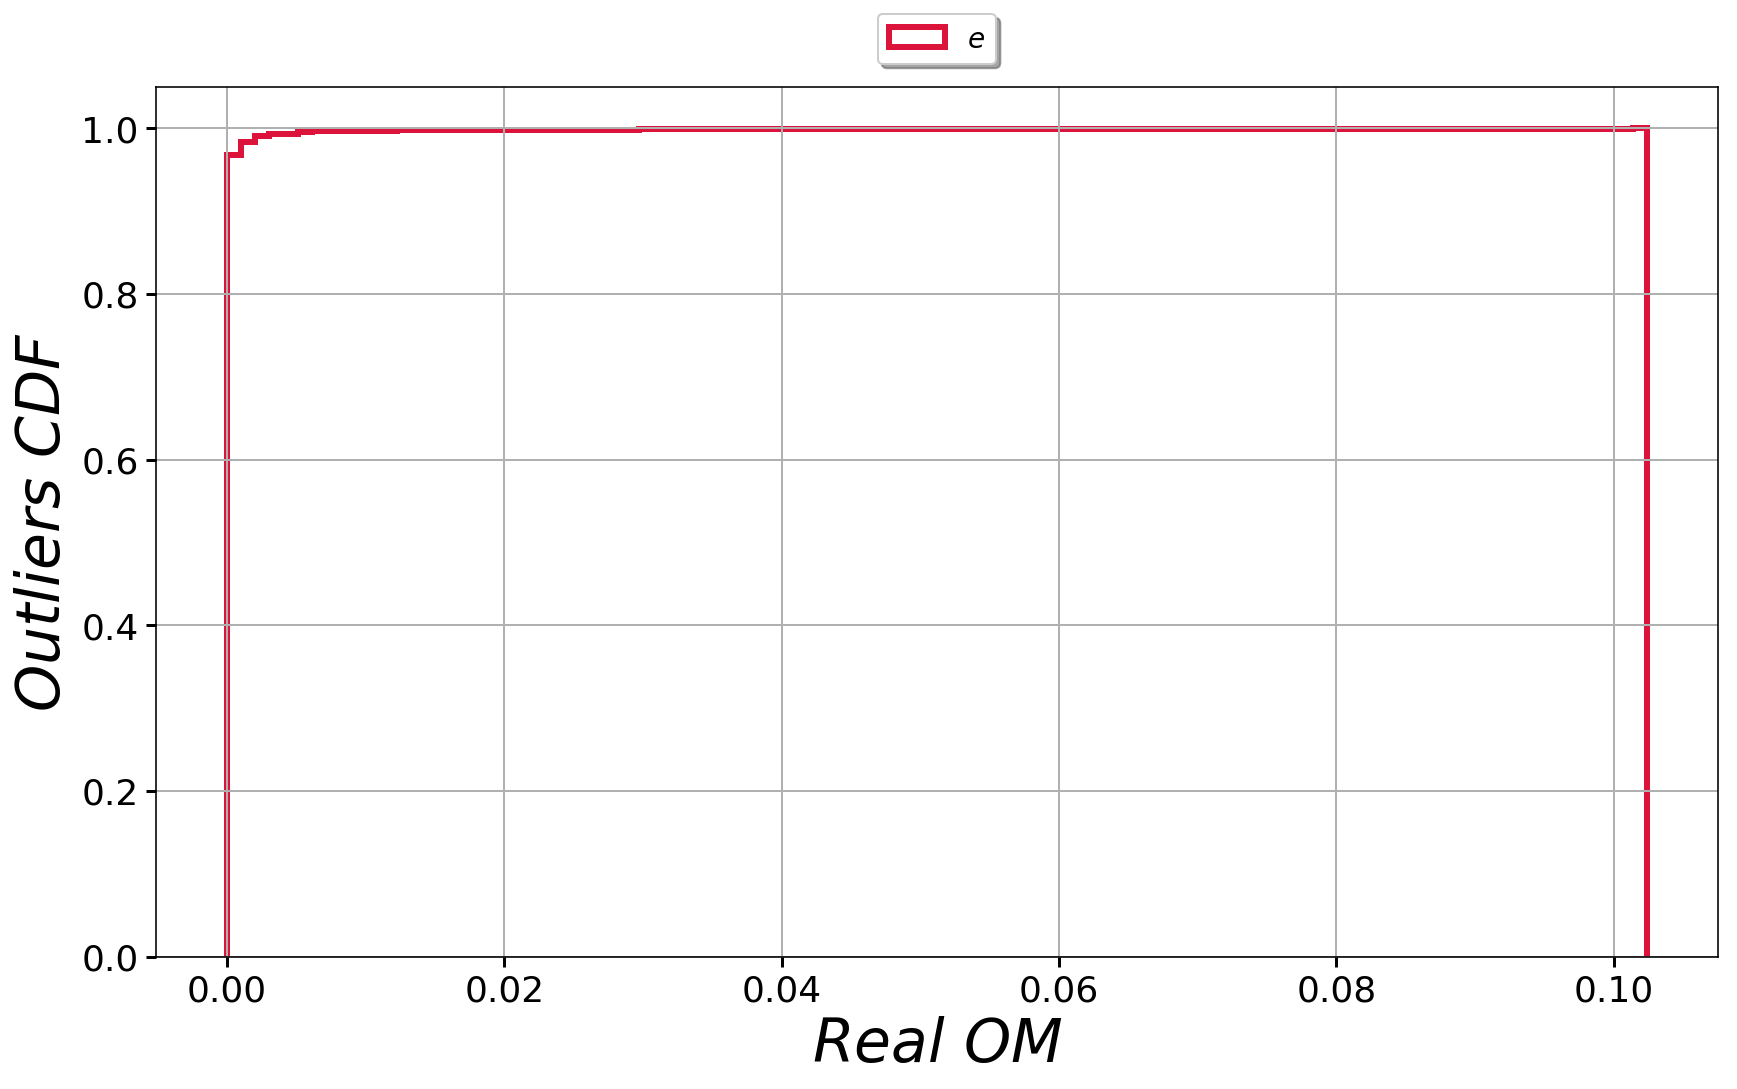

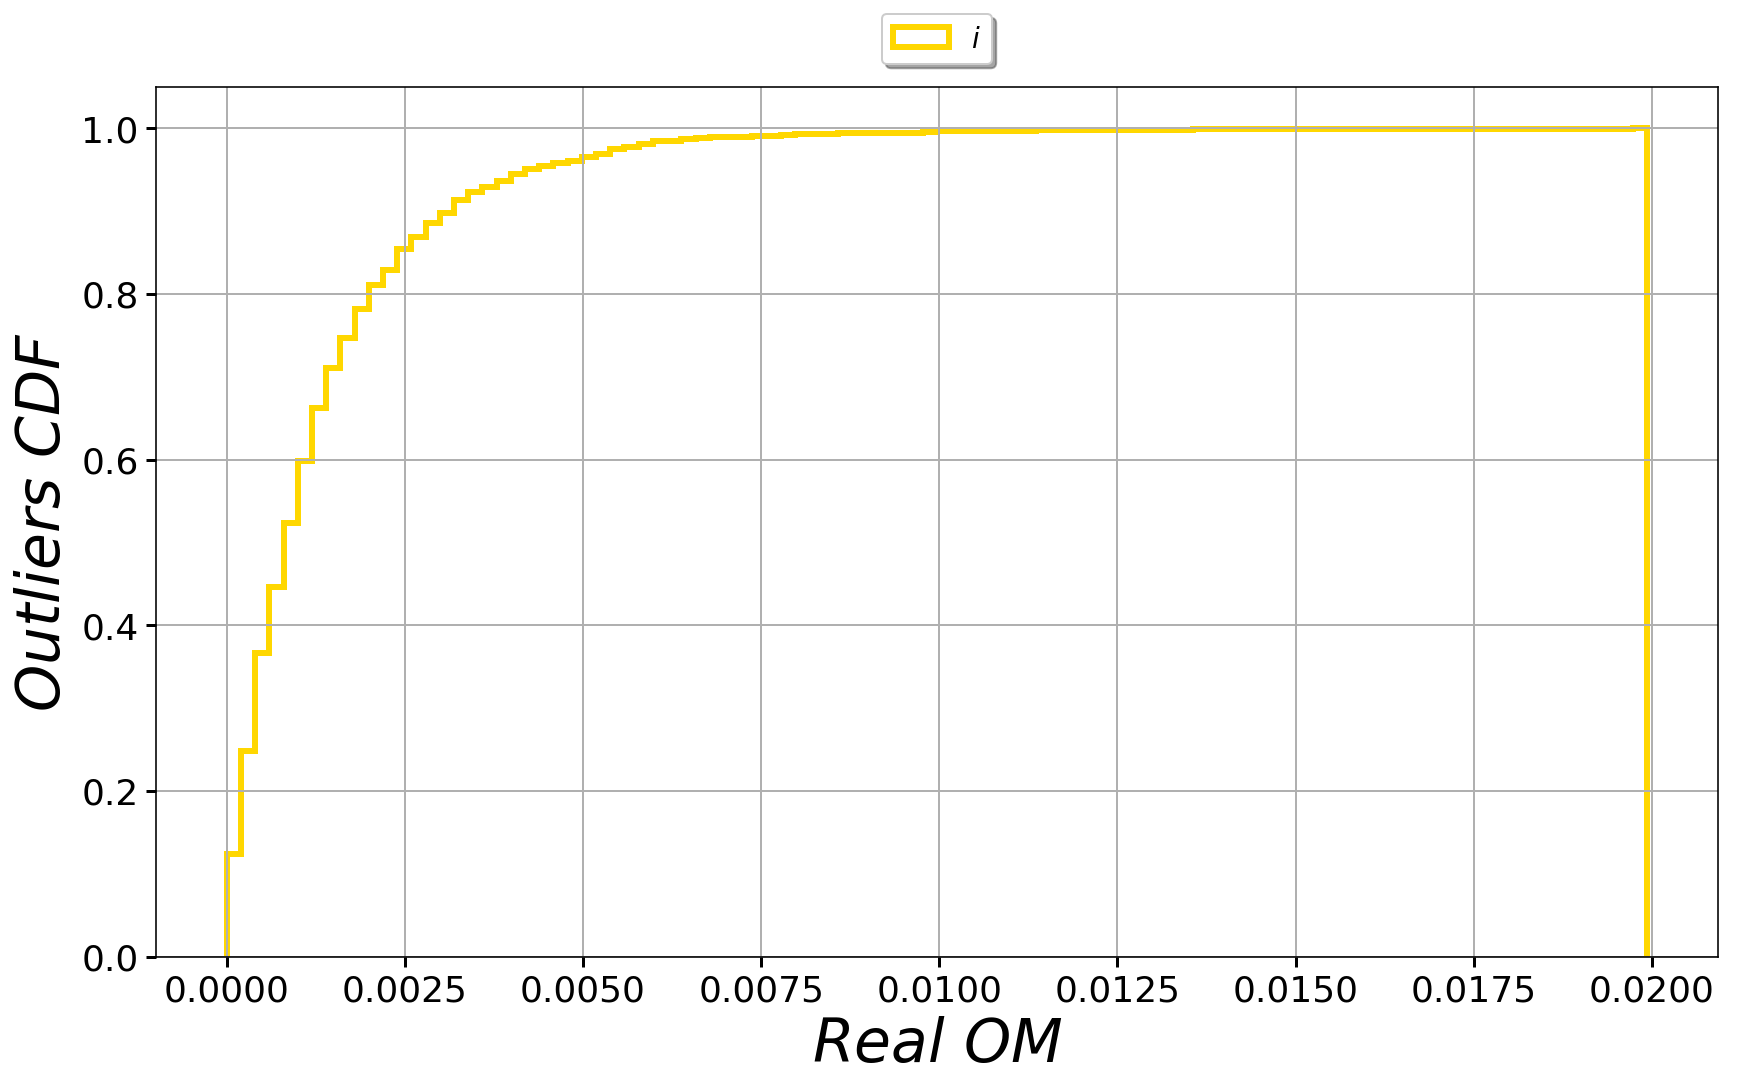

In [23]:
# Make histograms of the real OMs.
fig,ax=matplotlib.pyplot.subplots(1,1,sharex=True,figsize=(14,8))
ax.hist(realOM_n,100,color='indigo',histtype='step',density=True,cumulative=True,lw=3,label=r"$n$")
ax.set_ylabel(r"$No.\ outliers$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
ax.legend(bbox_to_anchor=(0.5,1.1),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=3)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xlabel(r"$Outliers\ CDF$", size=labelsFontSize)
fig.show()

fig,ax=matplotlib.pyplot.subplots(1,1,sharex=True,figsize=(14,8))
ax.hist(realOM_e,100,color='crimson',histtype='step',density=True,cumulative=True,lw=3,label=r"$e$")
ax.set_ylabel(r"$Outliers\ CDF$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
ax.legend(bbox_to_anchor=(0.5,1.1),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=3)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xlabel(r"$Real\ OM$", size=labelsFontSize)
fig.show()

fig,ax=matplotlib.pyplot.subplots(1,1,sharex=True,figsize=(14,8))
ax.hist(realOM_i,100,color='gold',histtype='step',density=True,cumulative=True,lw=3,label=r"$i$")
ax.set_ylabel(r"$Outliers\ CDF$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
ax.legend(bbox_to_anchor=(0.5,1.1),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=3)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xlabel(r"$Real\ OM$", size=labelsFontSize)
fig.show()

/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


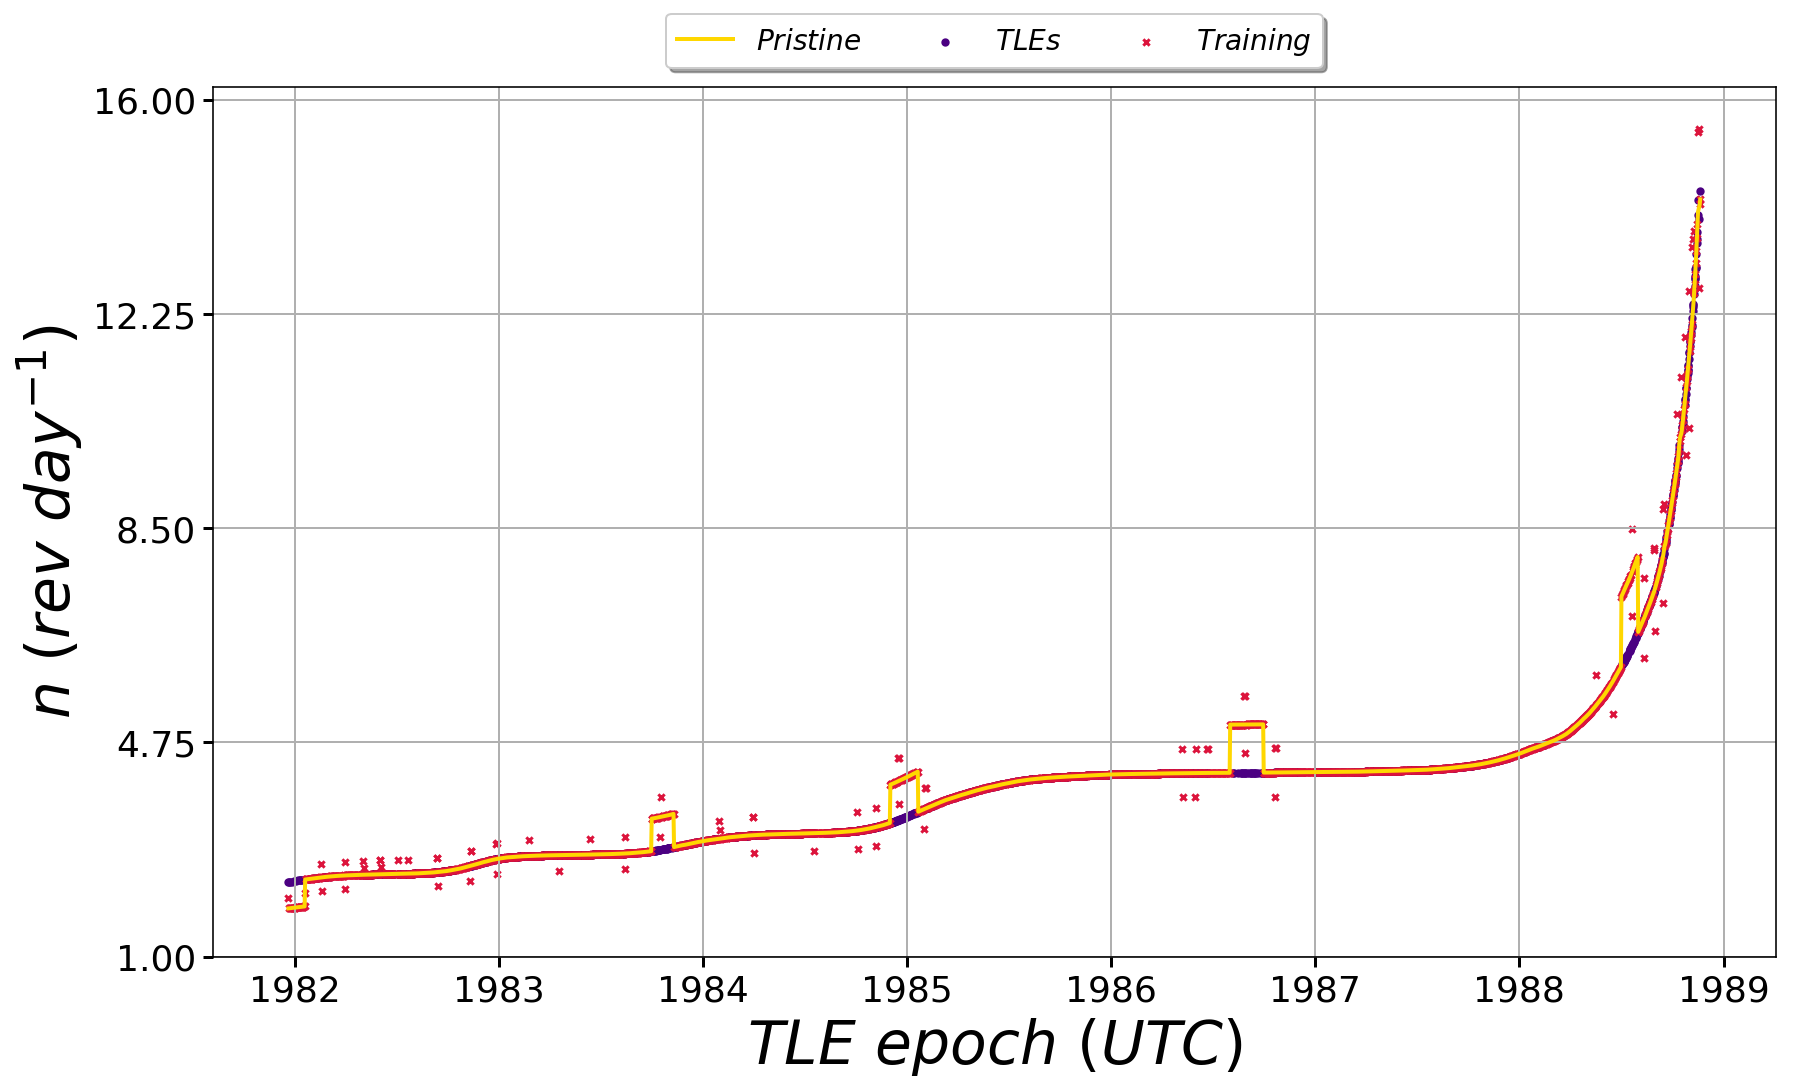

In [24]:
# Plot mean motion time series.
fig,ax=matplotlib.pyplot.subplots(1,1,sharex=True,figsize=(14,8))
ax.scatter(epochs,meanMotions,color='indigo',marker='o',s=10,label=r"$TLEs$")
ax.scatter(epochsOneDay,meanMotionTraining,color='crimson',
           marker='x',s=10,label=r"$Training$")
ax.plot(epochsOneDay,meanMotionPristine,ls='-',lw=2,c='gold',label=r'$Pristine$')
ax.set_ylabel(r"$n\ (rev\ day^{-1})$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
lower=min(meanMotions.min(),meanMotionTraining.min(),meanMotionPristine.min())
upper=max(meanMotions.max(),meanMotionTraining.max(),meanMotionPristine.max())
ax.set_yticks(numpy.linspace(numpy.floor(lower),numpy.ceil(upper),5) )
ax.legend(bbox_to_anchor=(0.5,1.1),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=3)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xlabel(r"$TLE\ epoch\ (UTC)$", size=labelsFontSize)
fig.show()

/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


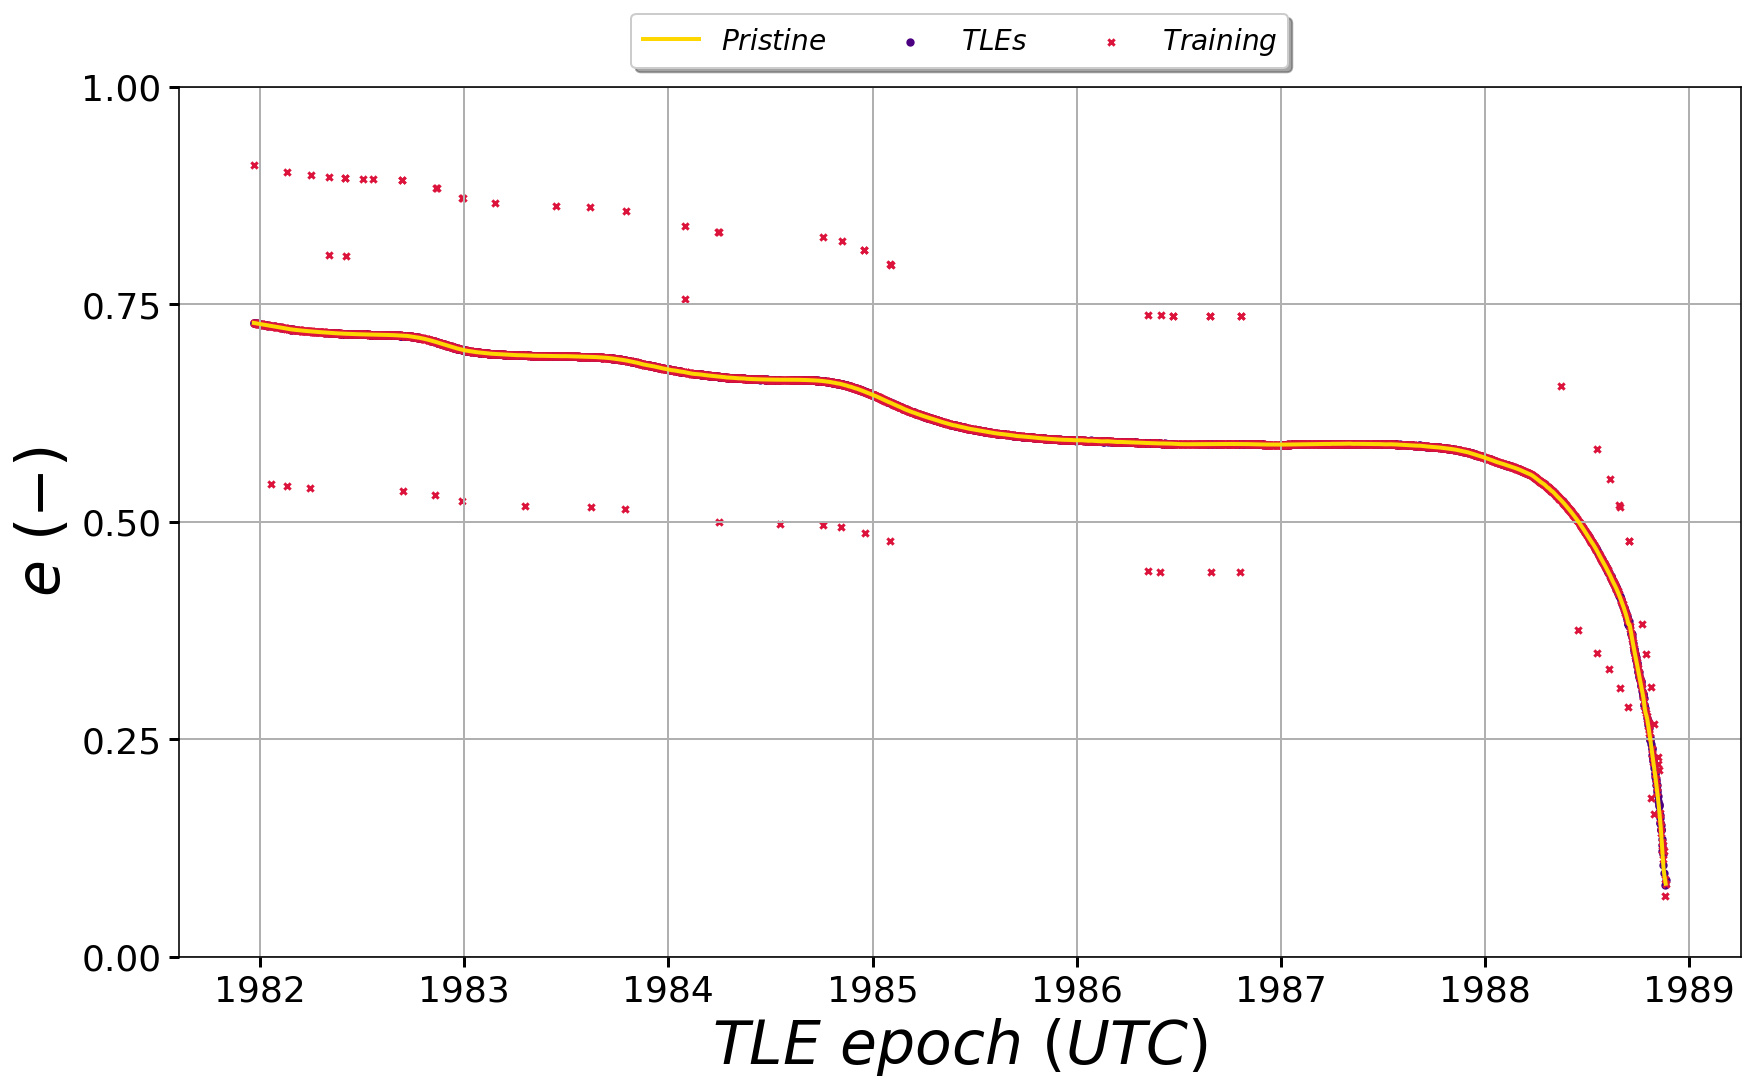

In [25]:
# Plot eccentricity time series.
fig,ax=matplotlib.pyplot.subplots(1,1,sharex=True,figsize=(14,8))
ax.scatter(epochs,eccentricities,color='indigo',marker='o',s=10,label=r"$TLEs$")
ax.scatter(epochsOneDay,eccentricityTraining,color='crimson',
           marker='x',s=10,label=r"$Training$")
ax.plot(epochsOneDay,eccentricityPristine,ls='-',lw=2,c='gold',label=r'$Pristine$')
ax.set_ylabel(r"$e\ (-)$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
lower=min(eccentricities.min(),eccentricityTraining.min(),eccentricityPristine.min())
upper=max(eccentricities.max(),eccentricityTraining.max(),eccentricityPristine.max())
ax.set_yticks(numpy.linspace(numpy.floor(lower),numpy.ceil(upper),5) )
ax.legend(bbox_to_anchor=(0.5,1.1),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=3)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xlabel(r"$TLE\ epoch\ (UTC)$", size=labelsFontSize)
fig.show()

/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


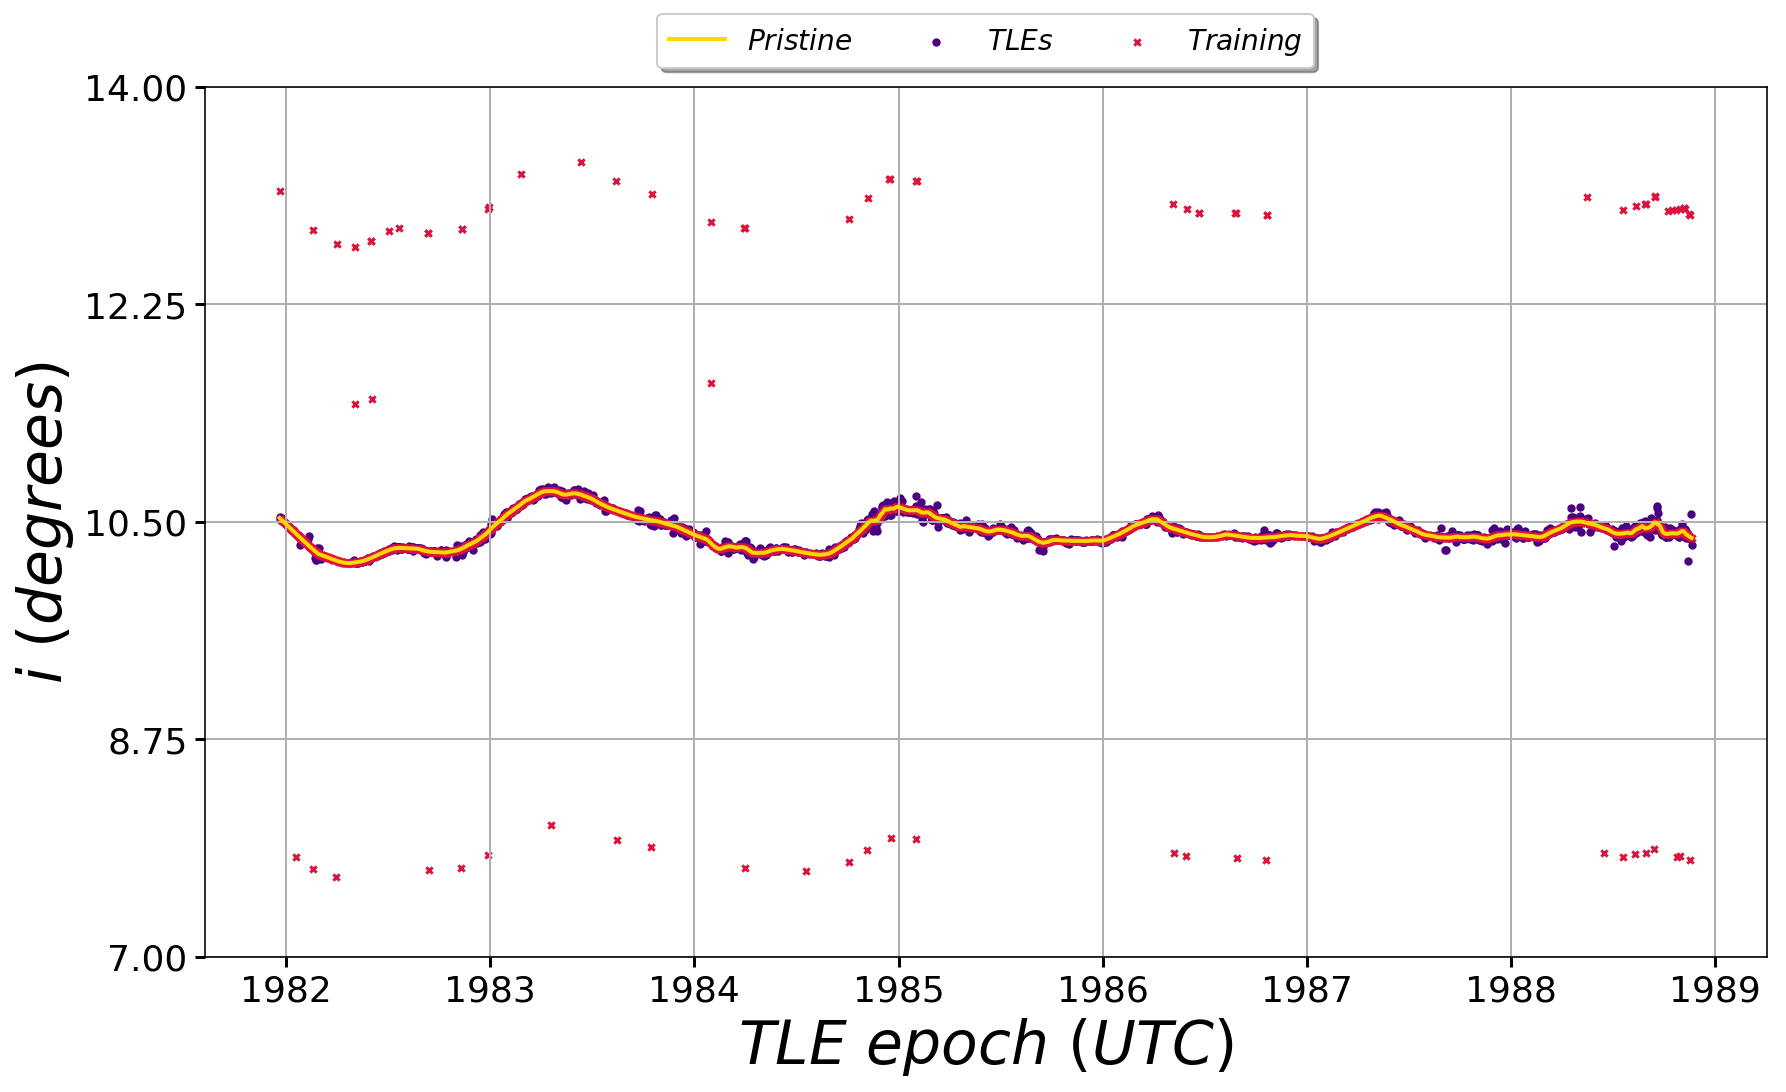

In [26]:
# Plot inclination time series.
fig,ax=matplotlib.pyplot.subplots(1,1,sharex=True,figsize=(14,8))
ax.scatter(epochs,inclinations,color='indigo',marker='o',s=10,label=r"$TLEs$")
ax.scatter(epochsOneDay,inclinationTraining,color='crimson',
           marker='x',s=10,label=r"$Training$")
ax.plot(epochsOneDay,inclinationPristine,ls='-',lw=2,c='gold',label=r'$Pristine$')
ax.set_ylabel(r"$i\ (degrees)$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
lower=min(inclinations.min(),inclinationTraining.min(),inclinationPristine.min())
upper=max(inclinations.max(),inclinationTraining.max(),inclinationPristine.max())
ax.set_yticks(numpy.linspace(numpy.floor(lower),numpy.ceil(upper),5) )
ax.legend(bbox_to_anchor=(0.5,1.1),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=3)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xlabel(r"$TLE\ epoch\ (UTC)$", size=labelsFontSize)
fig.show()